In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import json
import time
import itertools
from scipy import stats
import psycopg2 as psql
from psycopg2.extras import RealDictCursor

import seaborn as sns
sns.set(color_codes=True)

try:
    conn = psql.connect("dbname='thesisdata' user='postgres' host='localhost' password='postgres'")
except Exception as e:
    print("Unable to connect to the database.")
    print(e)

/home/victor/.local/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
def create_bounding_box(f):
    fuz = list(zip(*f))

    return [np.nanmin(fuz[0]), np.nanmax(fuz[0]), np.nanmin(fuz[1]), np.nanmax(fuz[1])]


def find_box_overlap(b1, b2):
    if (b1[0] <= b2[1]) & (b1[1] <= b2[0]) or (b1[2] <= b2[3]) & (b1[3] <= b2[2]):
        return None

    else:
        return [max([b1[0], b2[0]]), min([b1[1], b2[1]]), max([b1[2], b2[2]]), min([b1[3], b2[3]])]


def resample_flight(box, f):
    """Flights should be zipped list like zip(lat,lon)"""

    f_res = [(lat, lon, ts) for lat, lon, ts in f if (box[0] <= lat <= box[1]) & (box[2] <= lon <= box[3])]

    return f_res


def calc_coord_dst_simple(c1, c2):
    R = 6371.1 * 1000  # Radius of the Earth in m

    lon1 = c1[0]
    lat1 = c1[1]
    lon2 = c2[0]
    lat2 = c2[1]

    [lon1, lat1, lon2, lat2] = [math.radians(l) for l in [lon1, lat1, lon2, lat2]]

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    x = dlon * math.cos(dlat / 2)
    y = dlat
    d = math.sqrt(x * x + y * y) * R

    return d


def calc_coord_dst(c1, c2):
    R = 6371.1 * 1000  # Radius of the Earth in m

    lat1 = c1[0]
    lon1 = c1[1]
    lat2 = c2[0]
    lon2 = c2[1]

    [lon1, lat1, lon2, lat2] = [math.radians(l) for l in [lon1, lat1, lon2, lat2]]

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    d = R * c
    return d


def calc_bearing(c0, c1):
    if not all(isinstance(i, tuple) for i in [c0, c1]):
        return np.nan

    lat1 = c0[0]
    lon1 = c0[1]
    lat2 = c1[0]
    lon2 = c1[1]

    [lon1, lat1, lon2, lat2] = [math.radians(l) for l in [lon1, lat1, lon2, lat2]]

    dlon = lon2 - lon1

    x = math.cos(lat1) * math.sin(lat2) - math.sin(lat1) * math.cos(lat2) * math.cos(dlon)
    y = math.sin(dlon) * math.cos(lat2)
    bearing = math.atan2(y, x)

    return math.degrees(bearing)


def box_area(box):
    w = calc_coord_dst_simple([box[0], box[2]], [box[1], box[2]])
    h = calc_coord_dst_simple([box[0], box[2]], [box[0], box[3]])

    return w * h


def closest_distance(f1, f2):
    """Flights should be zipped list like zip(lat,lon)"""

    x = [[np.sqrt((c1[0] - c2[0]) ** 2 + (c1[1] - c2[1]) ** 2) for c1 in f1] for c2 in f2]
    dmin = np.nanmin(x)
    if2, if1 = np.where(x == dmin)

    c2 = f2[if2[0]]
    c1 = f1[if1[0]]
    dmin_m = calc_coord_dst(c1, c2)

    return dmin_m, c1, c2, if1[0], if2[0]


def closest_distance_2(f1, f2):
    """Flights should be zipped list like zip(lat,lon)"""

    x = [[(calc_coord_dst(c1, c2),c1,c2) for c1 in f1] for c2 in f2]
    xflat = [item for sublist in x for item in sublist]
    tupmin = min(xflat, key=itemgetter(2))
    
    dmin = tupmin[0]
    c1min = tupmin[1][:2]
    c2min = tupmin[2][:2]

    return dmin, c1min, c2min


def dst_aligned_times(f1, f2):
    """Flights should be zipped list like zip(lat,lon,ts)"""

    t = [[abs(c1[2] - c2[2]) for c1 in f1] for c2 in f2]
    tmin = np.nanmin(t)
    if2, if1 = np.where(t == tmin)


def find_flight_intersect(f1, f2):
    cnd = True
    first_it = True
    ba_old = None
    area_cnd = 0.95

    while cnd:
        f1_box = create_bounding_box(f1)
        f2_box = create_bounding_box(f2)

        obox = find_box_overlap(f1_box, f2_box)

        if obox:

            if not first_it:
                ba_old = ba
                ba = box_area(obox)
            else:
                ba = box_area(obox)

            if ba_old:
                if ba / ba_old > area_cnd:
                    return f1, f2

                else:

                    f1 = resample_flight(obox, f1)
                    f2 = resample_flight(obox, f2)
            else:

                f1 = resample_flight(obox, f1)
                f2 = resample_flight(obox, f2)

        else:
            return None, None

        if len(f1) == 0 or len(f2) == 0:
            return None, None

        first_it = False

        if len(f1) < 20:
            cnd = False

        # else:
        #     return None, None

    return f1, f2

def postprocess_conflict(b):

    ts_tol = 120

    df1 = pd.DataFrame()
    for k in ['ts_1', 'lat_1', 'lon_1', 'alt_1', 'spd_1', 'hdg_1', 'roc_1']:
        df1[k.strip('_1')] = b[k]
    df2 = pd.DataFrame()
    for k in ['ts_2', 'lat_2', 'lon_2', 'alt_2', 'spd_2', 'hdg_2', 'roc_2']:
        df2[k.strip('_2')] = b[k]

    df1 = df1.dropna(how='any', subset=['lat', 'lon', 'alt'])
    df2 = df2.dropna(how='any', subset=['lat', 'lon', 'alt'])

    if not len(df1) > 0:
        return None
    if not len(df2) > 0:
        return None

    if abs(df1['ts'].iloc[-1] - df2['ts'].iloc[-1]) > ts_tol:
        return None

    df1['ts'] = df1['ts'].astype(int)
    df2['ts'] = df2['ts'].astype(int)

    if df1['ts'].max() > df2['ts'].max():
        df_l = df1
        df_r = df2

        df_l['ts'] = df_l['ts'] - (df_l['ts'].iloc[-1] - df_r['ts'].iloc[-1])

        df_r['ts_n'] = df_r['ts'].astype(int)
        sfx = ('_1', '_2')
    else:
        df_l = df2
        df_r = df1

        df_l['ts'] = df_l['ts'] - (df_l['ts'].iloc[-1] - df_r['ts'].iloc[-1])

        df_r['ts_n'] = df_r['ts'].astype(int)
        sfx = ('_2', '_1')

    dfm = pd.merge_asof(df_l, df_r, on='ts', direction='nearest', tolerance=10, suffixes=sfx)

    dfm['td'] = dfm['ts'] - dfm['ts_n']
    dfm = dfm.dropna(how='any')
    if len(dfm) > 0:
        dfm['dstd'] = dfm.apply(lambda r: calc_coord_dst_pp(r['lat_1'], r['lon_1'], r['lat_2'], r['lon_2']), axis=1)
        dst = dfm['dstd'].iloc[-1].astype(float)
        dfm['ts_2'] = dfm['ts_n']
        dfm['ts_1'] = dfm['ts']

        b = dfm[['ts_1', 'lat_1', 'lon_1', 'alt_1', 'spd_1', 'hdg_1', 'roc_1',
                 'ts_2', 'lat_2', 'lon_2', 'alt_2', 'spd_2', 'hdg_2', 'roc_2']].astype(float).to_dict(orient='list')

        b['td'] = dfm['td'].iloc[-1].astype(float)
        b['altd'] = abs(dfm['alt_1'].iloc[-1].astype(float) - dfm['alt_2'].iloc[-1].astype(float))
        b['hdgd'] = abs(dfm['hdg_1'].iloc[-1].astype(float) - dfm['hdg_2'].iloc[-1].astype(float))
        b['dstd'] = dst

        return b

    else:
        return None

2485
97727.03181646988
(50.92796, 4.81674)
(50.0491, 4.81142)
172299.66475041324
(53.34027, 7.19863)
(53.12709, 4.63435)
1889.686778707307
(51.99401, 5.83178)
(51.9782, 5.8419)


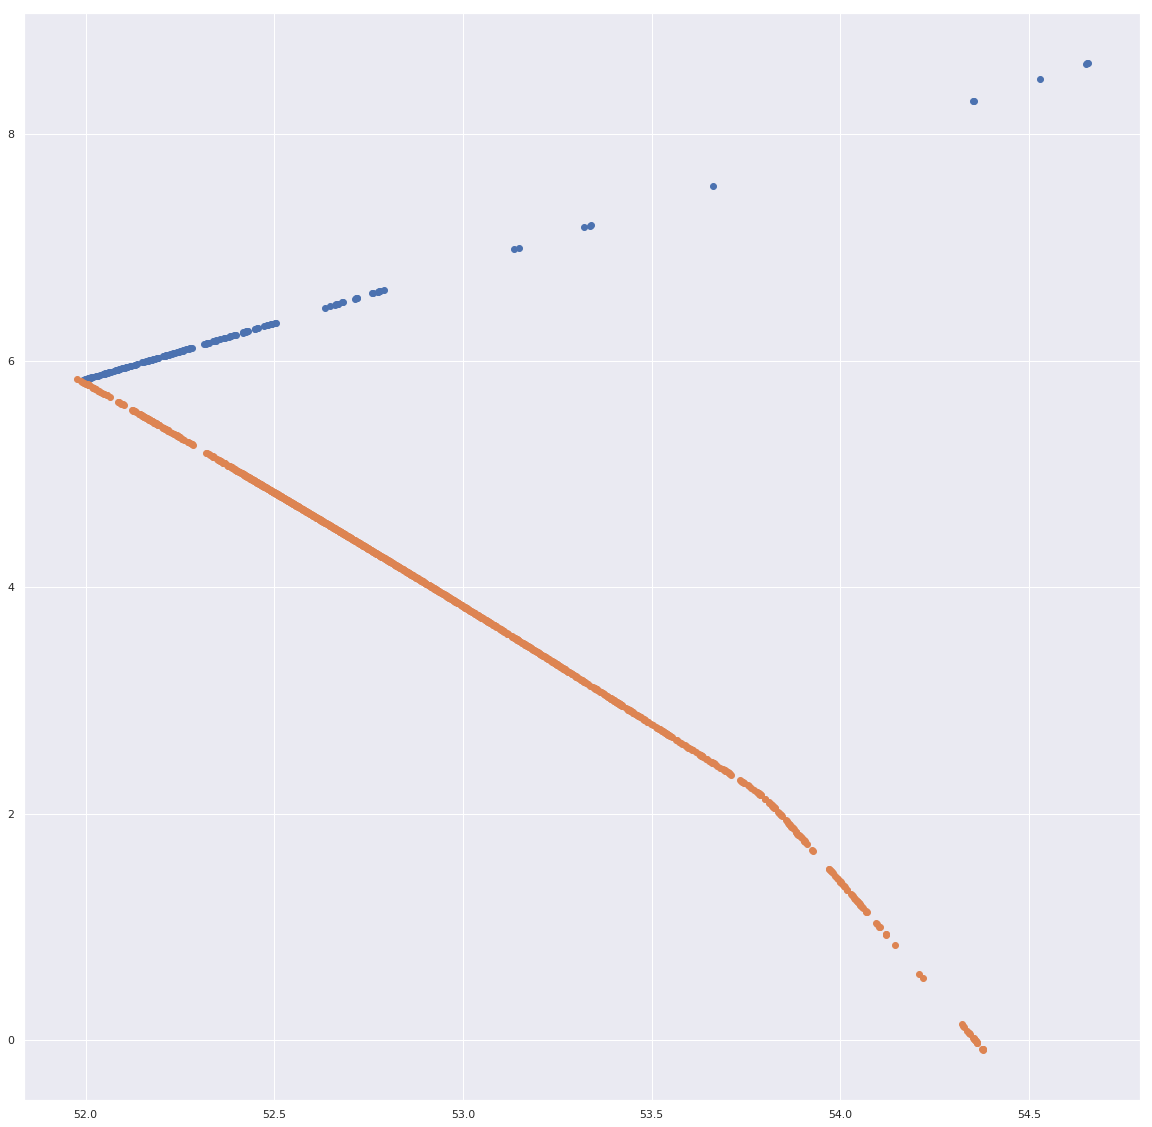

In [40]:
from operator import itemgetter

try:
    conn = psql.connect("dbname='thesisdata' user='postgres' host='localhost' password='postgres'")
except Exception as e:
    print("Unable to connect to the database.")
    print(e)

fl_start_ep = 1512225284
ts_offset = 1800
max_dst = 5 * 1852
avg_sec_msg = 10
alt_min = 25000
la_time = 1200

conn_read = conn
cur_read = conn_read.cursor(cursor_factory=RealDictCursor)
cur_read.execute("SELECT ts, lat, lon, alt, spd, hdg, roc, start_ep, flight_id \
                 FROM public.adsb_flights WHERE (end_ep - start_ep) > %s \
                 AND ((end_ep - start_ep) / flight_length) < %s \
                 AND start_ep BETWEEN %s AND %s;",
                 (la_time, avg_sec_msg, fl_start_ep - ts_offset, fl_start_ep + ts_offset))

f_list = []
fsets = []
sql_inj_lst = []
col_lst = ['td','altd','dstd','hdgd',
           'flight_id_1','ts_1','lat_1','lon_1','alt_1','spd_1','hdg_1','roc_1',
           'flight_id_2','ts_2','lat_2','lon_2','alt_2','spd_2','hdg_2','roc_2']

batch = cur_read.fetchall()

id_lst = [b['flight_id'] for b in batch]
fset = list(itertools.combinations(id_lst,2))

cnt = 1
print(len(fset))
    
for fs in fset:
    
    f1 = [f for f in batch if f['flight_id']==fs[0]][0]
    f2 = [f for f in batch if f['flight_id']==fs[1]][0]

    # f1 = {k: v for k, v in f1.items() if }
    f1crd = [(lt, ln, ts) for lt, ln, alt, ts in 
             list(zip(f1['lat'], f1['lon'], f1['alt'], f1['ts'])) if alt > alt_min]

    f2crd = [(lt, ln, ts) for lt, ln, alt, ts in 
             list(zip(f2['lat'], f2['lon'], f2['alt'], f2['ts'])) if alt > alt_min]

    if f1crd and f2crd:
        f1td = max(f1crd, key=itemgetter(2))[2] - min(f1crd, key=itemgetter(2))[2]
        f2td = max(f2crd, key=itemgetter(2))[2] - min(f2crd, key=itemgetter(2))[2]

        if f1td > la_time and f2td > la_time:

            t1 = time.time()

            fi1, fi2 = find_flight_intersect(f1crd, f2crd)

            if fi1 and fi2:

                d, c1, c2 = closest_distance_2(list(fi1), list(fi2))
    
                if d < max_dst: # and bdiff > 5 and tdiff < max_ts
                    
                    f1_df = pd.DataFrame.from_dict(f1)
                    f2_df = pd.DataFrame.from_dict(f2)
                    
                    f1_df = f1_df[f1_df['ts'] <= f1_df['ts'][(f1_df['lat'] == c1[0]) & (f1_df['lon'] == c1[1])].values[0]]
                    f2_df = f2_df[f2_df['ts'] <= f2_df['ts'][(f2_df['lat'] == c2[0]) & (f2_df['lon'] == c2[1])].values[0]]

                    confl = {}
                    for k in ['ts', 'lat', 'lon', 'alt', 'spd', 'hdg', 'roc']:
                        confl[('%s_1' % k)] = f1_df[k].values
                    for k in ['ts', 'lat', 'lon', 'alt', 'spd', 'hdg', 'roc']:
                        confl[('%s_2' % k)] = f2_df[k].values
                                
                    plt.figure(figsize=(20,20))
                    plt.scatter(confl['lat_1'], confl['lon_1'])
                    plt.scatter(confl['lat_2'], confl['lon_2'])
                    plt.show()
                                 
                    break
                    
                    confln = postprocess_conflict(confl)

                    if confln:

                        confln['flight_id_1'] = f1['flight_id']
                        confln['flight_id_2'] = f2['flight_id']

                        if confln['dstd'] < max_dst:

                            cnt = cnt + 1

                            try:
                                sql_inj_lst.append(tuple(confln[kk] for kk in col_lst))
                            except Exception as e1:
                                print(e1)

In [41]:
confln = postprocess_conflict(confl)

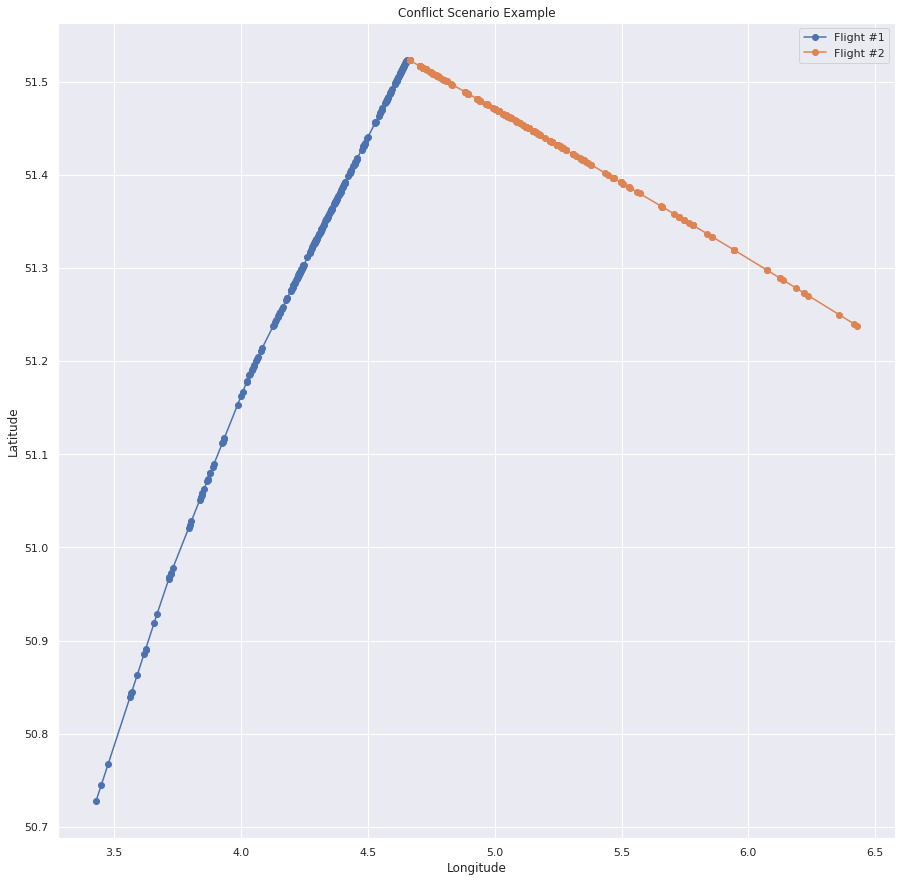

In [6]:
cur_read = conn.cursor(cursor_factory=RealDictCursor)
cur_read.execute("SELECT * FROM public.conflicts limit 1;")
batch = cur_read.fetchall()

plt.figure(figsize=(15,15))
for b in batch:
    
    fl_keys = ['ts', 'lat','lon','hdg','alt','spd','roc']
    
    
    
    for kx in ['_1','_2']:
        bn = {}
        for k in fl_keys:
            bn[k] = b["%s%s" % (k,kx)]

#         bn = crop_ddr2_flight(bn)
#         bnn = add_waypoints(bn)

        plt.plot(bn['lon'],bn['lat'], marker='o')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Conflict Scenario Example')
    plt.legend(['Flight #1', 'Flight #2'])

plt.show()

In [20]:
try:
    conn = psql.connect("dbname='thesisdata' user='postgres' host='localhost' password='postgres'")
except Exception as e:
    print("Unable to connect to the database.")
    print(e)

max_inserts = 100
fetch_batch_size = max_inserts
cnt = 0

fl_start_ep = 1512225284
fetch_batch_size = 500
ts_offset = 3600
max_dst = 5 * 1852
max_ts = 30
alt_min = 15000

cur_read = conn.cursor(cursor_factory=RealDictCursor)
cur_read.execute("SELECT ts, lat, lon, alt, start_ep, flight_id FROM public.adsb_flights WHERE flight_length > 1000 AND start_ep BETWEEN %s AND %s LIMIT 10;",
                (fl_start_ep - ts_offset, fl_start_ep + ts_offset))



f_list = []
fsets = []

batch = cur_read.fetchall()

id_lst = [b['flight_id'] for b in batch]
fset = list(itertools.combinations(id_lst,2))

print(fset)

cur.read.close()

[('4D00F5-3', '4CA93E-2'), ('4D00F5-3', '760916-2'), ('4D00F5-3', '4CA94B-1'), ('4D00F5-3', '76CD6C-1'), ('4D00F5-3', '4CA96C-3'), ('4D00F5-3', '780205-1'), ('4D00F5-3', 'C0584F-2'), ('4D00F5-3', '89912E-1'), ('4D00F5-3', '78076B-1'), ('4CA93E-2', '760916-2'), ('4CA93E-2', '4CA94B-1'), ('4CA93E-2', '76CD6C-1'), ('4CA93E-2', '4CA96C-3'), ('4CA93E-2', '780205-1'), ('4CA93E-2', 'C0584F-2'), ('4CA93E-2', '89912E-1'), ('4CA93E-2', '78076B-1'), ('760916-2', '4CA94B-1'), ('760916-2', '76CD6C-1'), ('760916-2', '4CA96C-3'), ('760916-2', '780205-1'), ('760916-2', 'C0584F-2'), ('760916-2', '89912E-1'), ('760916-2', '78076B-1'), ('4CA94B-1', '76CD6C-1'), ('4CA94B-1', '4CA96C-3'), ('4CA94B-1', '780205-1'), ('4CA94B-1', 'C0584F-2'), ('4CA94B-1', '89912E-1'), ('4CA94B-1', '78076B-1'), ('76CD6C-1', '4CA96C-3'), ('76CD6C-1', '780205-1'), ('76CD6C-1', 'C0584F-2'), ('76CD6C-1', '89912E-1'), ('76CD6C-1', '78076B-1'), ('4CA96C-3', '780205-1'), ('4CA96C-3', 'C0584F-2'), ('4CA96C-3', '89912E-1'), ('4CA96C-3'

NameError: name 'cur' is not defined

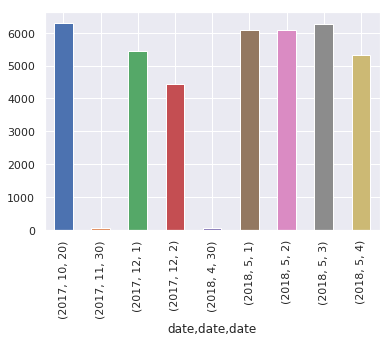

In [19]:
import pandas as pd
import datetime

try:
    conn = psql.connect("dbname='thesisdata' user='postgres' host='localhost' password='postgres'")
except Exception as e:
    print("Unable to connect to the database.")
    print(e)
    
cur_read = conn.cursor(cursor_factory=RealDictCursor)
cur_read.execute("SELECT start_ep, flight_id \
                 FROM public.adsb_flights;")

batch = cur_read.fetchall()

x = [b['start_ep'] for b in batch] 

daylst = list(set([datetime.datetime.fromtimestamp(xx).strftime('%Y-%m-%d %H') for xx in x]))
eplist = [(datetime.datetime.strptime(ts,'%Y-%m-%d %H') - datetime.datetime(1970, 1, 1)).total_seconds() for ts in daylst]

df = pd.DataFrame()
df['epoch'] = x
df['date'] = [datetime.datetime.fromtimestamp(d) for d in df['epoch']]
df['date'].groupby([df["date"].dt.year, df["date"].dt.month, df["date"].dt.day]).count().plot(kind="bar")

In [35]:
'%s_1' % 'bla'

'bla_1'

In [14]:
len(list(set(daylst)))

170

In [15]:
len(daylst)

40040

In [20]:
eplist

[1525370400.0,
 1525298400.0,
 1512198000.0,
 1525273200.0,
 1525179600.0,
 1525442400.0,
 1525190400.0,
 1512126000.0,
 1508457600.0,
 1512172800.0,
 1525302000.0,
 1512219600.0,
 1525147200.0,
 1525183200.0,
 1525327200.0,
 1525316400.0,
 1525435200.0,
 1512205200.0,
 1512122400.0,
 1508461200.0,
 1512255600.0,
 1512165600.0,
 1512133200.0,
 1525388400.0,
 1512248400.0,
 1525323600.0,
 1512176400.0,
 1525237200.0,
 1512252000.0,
 1525291200.0,
 1525266000.0,
 1525240800.0,
 1512104400.0,
 1525352400.0,
 1525413600.0,
 1508472000.0,
 1525201200.0,
 1512086400.0,
 1525356000.0,
 1508522400.0,
 1512244800.0,
 1525366800.0,
 1512234000.0,
 1525438800.0,
 1525251600.0,
 1512151200.0,
 1525374000.0,
 1512194400.0,
 1508464800.0,
 1512158400.0,
 1525150800.0,
 1525309200.0,
 1508511600.0,
 1525194000.0,
 1525406400.0,
 1508500800.0,
 1512169200.0,
 1525363200.0,
 1525161600.0,
 1512108000.0,
 1525136400.0,
 1525359600.0,
 1512187200.0,
 1525431600.0,
 1525226400.0,
 1512208800.0,
 152533440

In [1]:
conn.close()

NameError: name 'conn' is not defined